In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from itertools import combinations, permutations
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error
import random
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nbformat
import networkx as nx

In [2]:
def generate_dataset(dependency_type, n_samples=5000, threshold=0.2):
    """
    Generates a dataset based on the specified dependency type.
    
    Parameters:
        dependency_type (str): Type of functional relationship ('trigonometric', 'exponential', 
                               'threshold_max', 'threshold_conditional', 'power').
        n_samples (int): Number of samples to generate.
        threshold (float): Threshold for conditional dependency.

    Returns:
        pd.DataFrame: Dataset with selected dependency type.
    """

    np.random.seed(42)
    
    # Generate independent features
    X1 = np.random.uniform(-1, 1, n_samples)
    X2 = np.random.uniform(-1, 1, n_samples)
    X3 = np.random.uniform(-1, 1, n_samples)

    # Define dependencies
    if dependency_type == "multiplicative":
        Y = (X1 * X2 * X3) + np.random.normal(0, 0.05, n_samples)
    
    elif dependency_type == "conditional":
        Y = np.where(X3 > 0.5, X1 * X2, X2 * X3) + np.random.normal(0, 0.05, n_samples)

    elif dependency_type == "power":
        Y = X1**2 + X2**2 + X3**2 + np.random.normal(0, 0.05, n_samples)
    
    elif dependency_type == "sinusoidal":
        Y = np.sin(X1 * X2 * X3) + np.random.normal(0, 0.05, n_samples)

    elif dependency_type == "logarithmic":
        Y = np.log(1 + X1 * X2 * X3) + np.random.normal(0, 0.05, n_samples)
    elif dependency_type == "test":
        Y = X1 * X2**2 * X3**3 + np.random.normal(0, 0.05, n_samples)  

    else:
        raise ValueError("Invalid dependency type. Choose from ['multiplicative', 'conditional', 'power', 'sinusoidal', 'logarithmic']")
    
    
    # add filler features
    X4 = np.random.normal(-10, 10, n_samples)
    X5 = np.random.normal(-10, 10, n_samples)
    X6 = np.random.normal(-10, 10, n_samples)
    
    # Create DataFrame
    df = pd.DataFrame({'X1': X1, 'X2': X2, 'X3': X3, 'X4': X4, 'X5': X5, 'X6': X6, 'Y': Y})
    
    return df

# Example: Generate a dataset with an exponential dependency
dependency_type = "multiplicative"  # Change this to test different dependencies
df = generate_dataset(dependency_type)

display(df.sample(10))

,X1,X2,X3,X4,X5,X6,Y
1283,-0.980458,0.427215,-0.983528,-20.886277,1.025270,-4.089331,0.362574
2462,0.246812,0.827629,0.980220,-1.698823,-5.638769,-14.960736,0.190524
1008,-0.500664,0.253666,0.352112,-6.329532,-13.256213,-14.356216,-0.019900
1923,-0.289014,0.131777,0.958841,1.272811,0.939070,-8.808994,-0.006206
4094,-0.336057,0.026440,0.389215,-2.292169,-6.784554,-6.011693,0.003176
4938,0.524349,0.749011,-0.266263,-18.079952,-7.832599,-12.974642,-0.108580
2905,-0.890731,0.984184,0.192462,-9.793074,-11.898351,-15.286746,-0.180697
669,-0.429810,0.495041,-0.801611,-5.069136,-14.863918,-24.559650,0.143427
2557,-0.400869,0.015795,0.274782,-0.489431,-35.169956,2.274590,0.025246
2286,0.943065,0.089763,0.528025,-9.685825,-7.879070,-16.423214,0.032900


In [3]:
def analyze_feature_impacts(df, feature_list, target='Y', model_type='linear', poly_degree=2):
    """
    Evaluates all feature combinations and analyzes incremental impact of each feature addition using different models.
    
    Parameters:
    - df: DataFrame containing the dataset
    - feature_list: List of feature names to consider
    - target: The target variable (default: 'Y')
    - model_type: The model to use ('linear', 'poly', 'rf', 'mlp')
    - poly_degree: Degree for polynomial regression (default: 2)
    
    Returns:
    - combinations_df: DataFrame containing MSE for each feature combination
    - impact_df: DataFrame analyzing feature importance through MSE reduction
    """
    
    # First get all combinations and their MSEs
    combinations_results = []
    for r in range(1, len(feature_list) + 1):
        for feature_combo in combinations(feature_list, r):
            X = df[list(feature_combo)]
            y = df[target]
            
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled, y, test_size=0.2, random_state=42
            )
            
            # Choose model
            if model_type == 'linear':
                model = LinearRegression()
            elif model_type == 'poly':
                poly = PolynomialFeatures(degree=poly_degree, include_bias=False)
                X_train = poly.fit_transform(X_train)
                X_test = poly.transform(X_test)
                model = LinearRegression()
            elif model_type == 'rf':
                model = RandomForestRegressor(n_estimators=300, random_state=43 ,max_depth=10)
            elif model_type == 'mlp':
                model = MLPRegressor(hidden_layer_sizes=(20), activation='relu', max_iter=500, random_state=42)
            else:
                raise ValueError("Invalid model_type. Choose from 'linear', 'poly', 'rf', or 'mlp'.")

            # Train and evaluate
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            
            combinations_results.append({
                'features': feature_combo,
                'num_features': len(feature_combo),
                'mse': mse,
                'rmse': np.sqrt(mse)
            })
    
    # Create impact analysis
    impact_results = []
    for result in combinations_results:
        if len(result['features']) > 1:
            current_mse = result['mse']
            current_features = set(result['features'])
            
            # Find the MSE for each subset with one feature removed
            for feature in result['features']:
                subset_features = current_features - {feature}
                
                # Find the corresponding base MSE
                base_mse = next(r['mse'] for r in combinations_results 
                              if set(r['features']) == subset_features)
                
                impact_results.append({
                    'base_features': tuple(sorted(subset_features)),
                    'added_feature': feature,
                    'final_features': result['features'],
                    'base_mse': base_mse,
                    'new_mse': current_mse,
                    'mse_reduction': base_mse - current_mse,
                    'relative_improvement': ((base_mse - current_mse) / base_mse) * 100
                })
    
    # Convert to DataFrame and sort by MSE reduction
    impact_df = pd.DataFrame(impact_results).sort_values('mse_reduction', ascending=False)
    
    # Convert combinations results to DataFrame
    combinations_df = pd.DataFrame(combinations_results).sort_values('mse')
    
    return combinations_df, impact_df


# List of features for diabetes dataset
features_to_test = df.columns.tolist()[:-1]
# combinations_df, impact_df = analyze_feature_impacts(df, features_to_test, model_type="poly", poly_degree=3)
# combinations_df, impact_df = analyze_feature_impacts(df, features_to_test, model_type="mlp")
combinations_df, impact_df = analyze_feature_impacts(df, features_to_test, model_type="rf")



# display(combinations_df)
# display(impact_df.sort_values("added_feature", ascending=True))
# display(impact_df[impact_df["added_feature"] == "X2"])
display(impact_df.sort_values("mse_reduction", ascending=False).head(15))



,base_features,added_feature,final_features,base_mse,new_mse,mse_reduction,relative_improvement
32,"(X1, X2)",X3,"(X1, X2, X3)",0.042865,0.018770,0.024095,56.211376
31,"(X1, X3)",X2,"(X1, X2, X3)",0.042203,0.018770,0.023433,55.523865
95,"(X1, X3, X5)",X2,"(X1, X2, X3, X5)",0.042711,0.019541,0.023170,54.248289
96,"(X1, X2, X5)",X3,"(X1, X2, X3, X5)",0.042665,0.019541,0.023124,54.199542
100,"(X1, X2, X6)",X3,"(X1, X2, X3, X6)",0.042694,0.019804,0.022891,53.615114
30,"(X2, X3)",X1,"(X1, X2, X3)",0.041381,0.018770,0.022611,54.640752
92,"(X1, X2, X4)",X3,"(X1, X2, X3, X4)",0.042323,0.020148,0.022175,52.395519
94,"(X2, X3, X5)",X1,"(X1, X2, X3, X5)",0.041712,0.019541,0.022171,53.152513
162,"(X1, X2, X5, X6)",X3,"(X1, X2, X3, X5, X6)",0.042299,0.020461,0.021838,51.628318
99,"(X1, X3, X6)",X2,"(X1, X2, X3, X6)",0.041581,0.019804,0.021778,52.373649


In [14]:
df.to_csv("test_5000_new.csv", index=False)

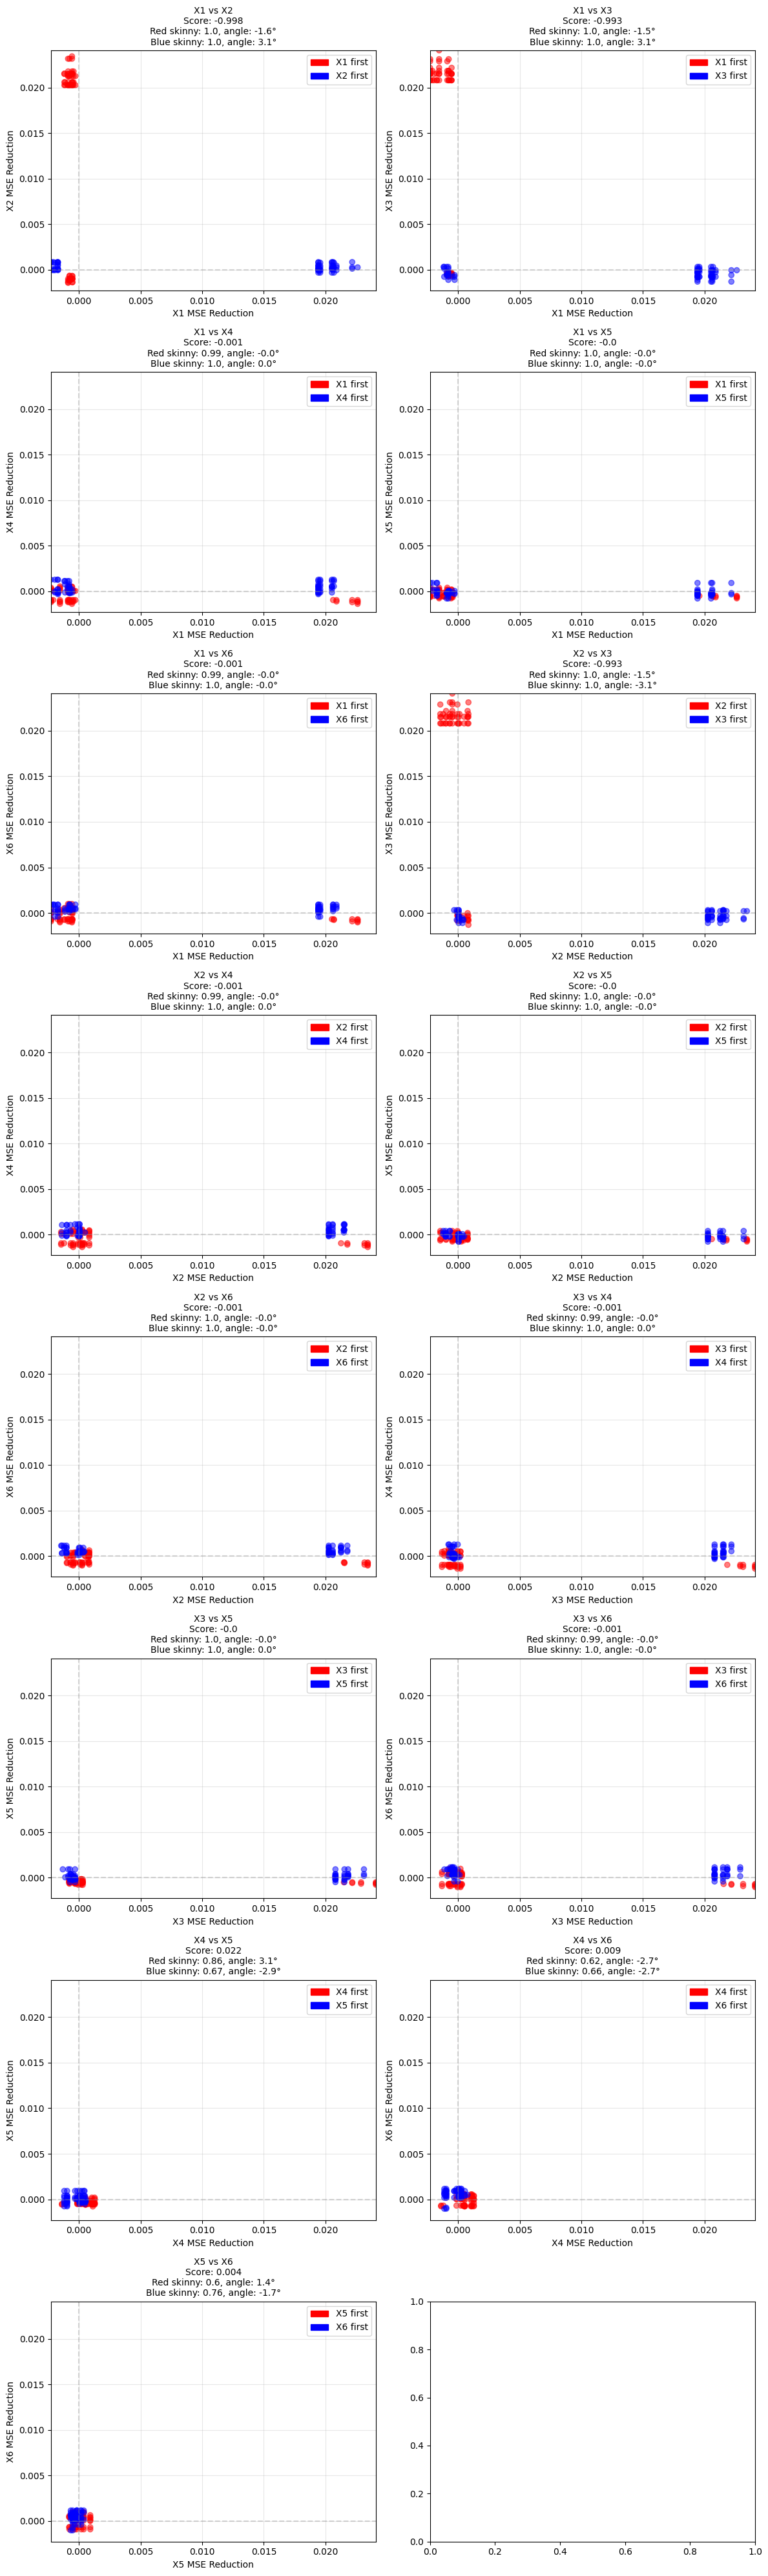

In [5]:
L_score_dict = {}

# Function to compute PCA metrics safely
def compute_pca_metrics(data):
    """Computes skinniness and horizontalness from PCA with error handling"""
    if len(data) < 3:  # Too few points for PCA
        return 1, 0, 0  # Neutral values
    
    pca = PCA(n_components=2)
    pca.fit(data)
    
    # Compute skinniness (avoid division errors)
    explained_variance = pca.explained_variance_ratio_
    skinniness = explained_variance[0] / explained_variance[1]
    skinniness = skinniness / (1 + skinniness)
    
    # Compute angle of first principal component
    first_component = pca.components_[0]
    angle = np.degrees(np.arctan2(first_component[1], first_component[0]))
    
    # Convert angle to horizontalness score
    horizontalness = np.cos(2 * np.radians(angle))
    
    return skinniness, horizontalness, angle

# Get unique features from the dataframe
features = np.sort(impact_df['added_feature'].unique())

# Create all possible feature pairs
feature_pairs = [(f1, f2) for i, f1 in enumerate(features) for f2 in features[i+1:]]

# Find global min and max of mse_reduction to standardize axes
global_min = impact_df['mse_reduction'].min()
global_max = impact_df['mse_reduction'].max()

# Create plots for all feature pairs
fig, axes = plt.subplots(nrows=len(feature_pairs)//2 + 1, ncols=2, figsize=(12, 5 * (len(feature_pairs)//2 + 1)))

for ax, (feature1, feature2) in zip(axes.flatten(), feature_pairs):
    points = []  # Store (x, y, color)

    for row in impact_df.itertuples(index=False):
        if feature1 in row.added_feature and feature2 not in row.base_features:
            for row2 in impact_df.itertuples(index=False):
                if set(row.final_features) <= set(row2.base_features) and feature2 in row2.added_feature:
                    points.append((row.mse_reduction, row2.mse_reduction, 'red'))
        elif feature2 in row.added_feature and feature1 not in row.base_features:
            for row2 in impact_df.itertuples(index=False):
                if set(row.final_features) <= set(row2.base_features) and feature1 in row2.added_feature:
                    points.append((row2.mse_reduction, row.mse_reduction, 'blue'))

        # Handle feature1 or feature2 being the only feature present
        elif set([row.base_features]) == {feature1}:  # Only feature1 is added
            points.append((row.mse_reduction, 0, 'red'))
        elif set([row.base_features]) == {feature2}:  # Only feature2 is added
            points.append((0, row.mse_reduction, 'blue'))

    # Extract values for plotting
    if points:
        red_points = [p for p in points if p[2] == 'red']
        blue_points = [p for p in points if p[2] == 'blue']

        # Sample up to 500 points for efficiency
        red_points = random.sample(red_points, min(len(red_points), 600))
        blue_points = random.sample(blue_points, min(len(blue_points), 600))

        points = red_points + blue_points

        # Convert to numpy arrays for PCA
        x_vals, y_vals, colors = zip(*points)
        x_vals, y_vals = np.array(x_vals), np.array(y_vals)

        # Prepare data for PCA
        red_array = np.array([(x, y) for x, y, c in points if c == 'red'])
        blue_array = np.array([(x, y) for x, y, c in points if c == 'blue'])

        # Compute PCA metrics with fixes
        red_skinny, red_horiz, red_angle = compute_pca_metrics(red_array)
        blue_skinny, blue_horiz, blue_angle = compute_pca_metrics(blue_array)

        # Compute L-score safely
        L_score = (red_skinny * blue_skinny) * (red_horiz - blue_horiz) / 2
        L_score = round(L_score, 3)

    else:
        x_vals, y_vals, colors = [], [], []
        L_score = None  # No valid data for computation

    # Scatter plot
    ax.scatter(x_vals, y_vals, c=colors, alpha=0.5)

    # Add reference lines
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

    # **Standardize axes for all plots**
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(global_min, global_max)

    # Set title with L-score and PCA details
    if L_score is not None:
        ax.set_title(
            f'{feature1} vs {feature2}\n'
            f'Score: {L_score}\n'
            f'Red skinny: {round(red_skinny, 2)}, angle: {round((np.deg2rad(red_angle)), 1)}°\n'
            f'Blue skinny: {round(blue_skinny, 2)}, angle: {round((np.deg2rad(blue_angle)), 1)}°',
            fontsize=10
        )
        L_score_dict[(feature1, feature2)] = L_score
    else:
        ax.set_title(f'{feature1} vs {feature2} | No Valid Data', fontsize=10)

    ax.set_xlabel(f'{feature1} MSE Reduction', fontsize=10)
    ax.set_ylabel(f'{feature2} MSE Reduction', fontsize=10)

    # Add custom legend
    red_patch = mpatches.Patch(color='red', label=f'{feature1} first')
    blue_patch = mpatches.Patch(color='blue', label=f'{feature2} first')
    ax.legend(handles=[red_patch, blue_patch], loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


[-0.00070632  0.01462246]
-0.9999968285945009
[0.01375799 0.00029151]
0.9999136148652831
[-0.00121121  0.01515617]
-0.9977098353296523
[ 0.01408074 -0.00042166]
0.999968566032292
[ 0.00209595 -0.00044167]
0.997896432251374
[0.00912127 0.0004306 ]
0.99991782129668
[ 0.00203696 -0.00030776]
0.9995727516852836
[ 9.33633353e-03 -8.02540923e-05]
0.9999661093108205
[ 0.00208864 -0.00021133]
0.9983817240526962
[0.0091633  0.00046256]
0.9999999211745152
[-0.00012826  0.01516278]
-0.9977125216329555
[ 0.01495182 -0.00033653]
0.9999890243605577
[ 0.00311203 -0.00043617]
0.9978535412799865
[0.00999125 0.00044886]
0.9999349463424129
[ 0.00297348 -0.00032723]
0.9996202898782165
[ 0.01018133 -0.00014155]
0.9999572336761533
[ 0.00322083 -0.00027228]
0.9986530670399288
[0.00996683 0.00059693]
0.999999994512578
[ 0.00281195 -0.00038271]
0.9975355499390199
[0.01025567 0.00035706]
0.9999297597797184
[ 0.00304897 -0.00046206]
0.9999223160331775
[0.01025747 0.00014222]
0.9999688113714832
[ 0.00294162 -0.00

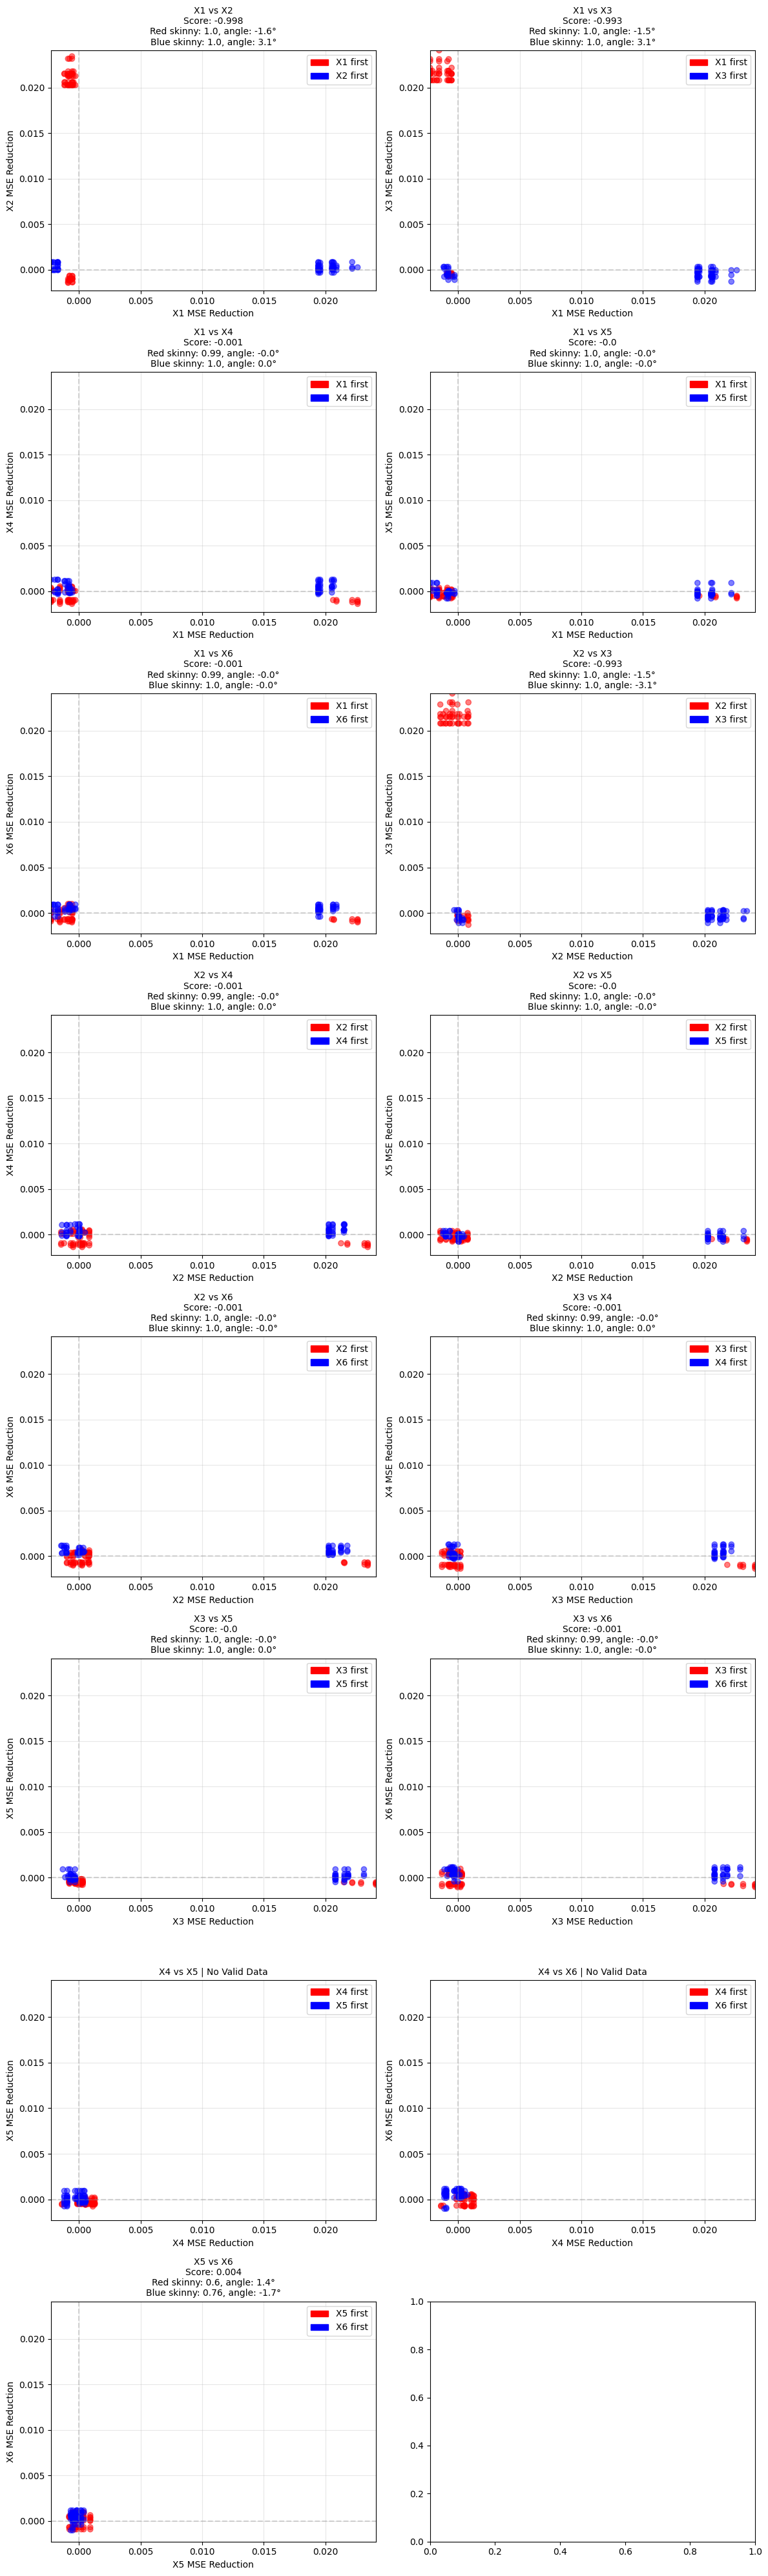

In [ ]:

L_score_dict = {}

# Function to compute PCA metrics with orientation validation
def compute_pca_metrics(data):
    if len(data) < 3:
        return 1, 0, 0, False

    pca = PCA(n_components=2)
    pca.fit(data)

    explained_variance = pca.explained_variance_ratio_
    if explained_variance[1] == 0:
        skinniness = 1  # or 0, but 1 is safe linear fallback
    else:
        skinniness = explained_variance[0] / explained_variance[1]
        skinniness = skinniness / (1 + skinniness)

    first_component = pca.components_[0]
    angle = np.degrees(np.arctan2(first_component[1], first_component[0]))
    horizontalness = np.cos(2 * np.radians(angle))

    centroid = np.mean(data, axis=0)
    # print(centroid)
    # print(horizontalness)
    if horizontalness > 0:
        correct_orientation = centroid[0] > 0
    elif horizontalness < 0:
        correct_orientation = centroid[1] > 0
    else:
        correct_orientation = False

    if np.any(np.isnan([skinniness, horizontalness, angle])):
        return 1, 0, 0, False

    return skinniness, horizontalness, angle, correct_orientation

# Replace this with your actual DataFrame
# impact_df should have 'added_feature', 'base_features', 'final_features', 'mse_reduction'
# Mock example:
# impact_df = pd.DataFrame({
#     'added_feature': np.random.choice(['X1', 'X2', 'X3'], size=300),
#     'base_features': np.random.choice(['X1', 'X2', 'X3'], size=300),
#     'final_features': [set(random.sample(['X1', 'X2', 'X3'], k=2)) for _ in range(300)],
#     'mse_reduction': np.random.normal(loc=0.05, scale=0.02, size=300)
# })

features = np.sort(impact_df['added_feature'].unique())
feature_pairs = [(f1, f2) for i, f1 in enumerate(features) for f2 in features[i+1:]]

global_min = impact_df['mse_reduction'].min()
global_max = impact_df['mse_reduction'].max()

fig, axes = plt.subplots(nrows=len(feature_pairs)//2 + 1, ncols=2, figsize=(12, 5 * (len(feature_pairs)//2 + 1)))

for ax, (feature1, feature2) in zip(axes.flatten(), feature_pairs):
    points = []

    for row in impact_df.itertuples(index=False):
        if feature1 in row.added_feature and feature2 not in row.base_features:
            for row2 in impact_df.itertuples(index=False):
                if set(row.final_features) <= set(row2.base_features) and feature2 in row2.added_feature:
                    points.append((row.mse_reduction, row2.mse_reduction, 'red'))
        elif feature2 in row.added_feature and feature1 not in row.base_features:
            for row2 in impact_df.itertuples(index=False):
                if set(row.final_features) <= set(row2.base_features) and feature1 in row2.added_feature:
                    points.append((row2.mse_reduction, row.mse_reduction, 'blue'))
        elif set([row.base_features]) == {feature1}:
            points.append((row.mse_reduction, 0, 'red'))
        elif set([row.base_features]) == {feature2}:
            points.append((0, row.mse_reduction, 'blue'))

    if points:
        red_points = [p for p in points if p[2] == 'red']
        blue_points = [p for p in points if p[2] == 'blue']

        red_points = random.sample(red_points, min(len(red_points), 300))
        blue_points = random.sample(blue_points, min(len(blue_points), 300))

        points = red_points + blue_points
        x_vals, y_vals, colors = zip(*points)
        x_vals, y_vals = np.array(x_vals), np.array(y_vals)

        red_array = np.array([(x, y) for x, y, c in points if c == 'red'])
        blue_array = np.array([(x, y) for x, y, c in points if c == 'blue'])

        red_skinny, red_horiz, red_angle, red_ok = compute_pca_metrics(red_array)
        blue_skinny, blue_horiz, blue_angle, blue_ok = compute_pca_metrics(blue_array)

        if red_ok and blue_ok:
            L_score = (red_skinny * blue_skinny) * (red_horiz - blue_horiz) / 2
            L_score = round(L_score, 3)
        else:
            L_score = None
    else:
        x_vals, y_vals, colors = [], [], []
        L_score = None

    ax.scatter(x_vals, y_vals, c=colors, alpha=0.5)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3)
    ax.set_xlim(global_min, global_max)
    ax.set_ylim(global_min, global_max)

    if L_score is not None:
        ax.set_title(
            f'{feature1} vs {feature2}\n'
            f'Score: {L_score}\n'
            f'Red skinny: {round(red_skinny, 2)}, angle: {round(np.deg2rad(red_angle), 1)}°\n'
            f'Blue skinny: {round(blue_skinny, 2)}, angle: {round(np.deg2rad(blue_angle), 1)}°',
            fontsize=10
        )
        L_score_dict[(feature1, feature2)] = L_score
    else:
        ax.set_title(f'{feature1} vs {feature2} | No Valid Data', fontsize=10)

    ax.set_xlabel(f'{feature1} MSE Reduction', fontsize=10)
    ax.set_ylabel(f'{feature2} MSE Reduction', fontsize=10)
    red_patch = mpatches.Patch(color='red', label=f'{feature1} first')
    blue_patch = mpatches.Patch(color='blue', label=f'{feature2} first')
    ax.legend(handles=[red_patch, blue_patch], loc='upper right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:


# Function to compute PCA metrics remains the same
def compute_pca_metrics_3d(data):
    if len(data) < 4:
        return 1, 0, 0, 0
    pca = PCA(n_components=3)
    pca.fit(data)
    explained_variance = pca.explained_variance_ratio_
    skinniness = explained_variance[0] / (explained_variance[1] + explained_variance[2])
    skinniness = skinniness / (1 + skinniness)
    first_component = pca.components_[0]
    angle_x = np.degrees(np.arctan2(first_component[1], first_component[0]))
    angle_y = np.degrees(np.arctan2(first_component[2], first_component[0]))
    horizontalness = np.cos(2 * np.radians(angle_x)) * np.cos(2 * np.radians(angle_y))
    return skinniness, horizontalness, angle_x, angle_y

features = impact_df['added_feature'].unique()
feature_triplets = [('X1', 'X2', 'X3')]

for f1, f2, f3 in feature_triplets:
    fig = make_subplots(
    rows=len(feature_triplets), cols=1,
    specs=[[{'type': 'scatter3d'}]] * len(feature_triplets),
    subplot_titles=[f"{f1}, {f2}, {f3}"],
    )

    fig.update_layout(
        scene=dict(
            xaxis_title=f"{f1} MSE Reduction",
            yaxis_title=f"{f2} MSE Reduction",
            zaxis_title=f"{f3} MSE Reduction"
        )
    )



for idx, (feature1, feature2, feature3) in enumerate(feature_triplets):
    points = []
                            
                            
    for row in impact_df.itertuples(index=False):
        if feature1 in row.added_feature and feature2 not in row.base_features and feature3 not in row.base_features:
            for row2 in impact_df.itertuples(index=False):
                if set(row.final_features) <= set(row2.base_features) and feature2 in row2.added_feature and feature3 not in row2.base_features:
                    for row3 in impact_df.itertuples(index=False):
                        if set(row2.final_features) <= set(row3.base_features) and feature3 in row3.added_feature:
                            points.append((row.mse_reduction, row2.mse_reduction, row3.mse_reduction, 'red'))
        elif feature2 in row.added_feature and feature1 not in row.base_features and feature3 not in row.base_features:
            for row2 in impact_df.itertuples(index=False):
                if set(row.final_features) <= set(row2.base_features) and feature1 in row2.added_feature and feature3 not in row2.base_features:
                    for row3 in impact_df.itertuples(index=False):
                        if set(row2.final_features) <= set(row3.base_features) and feature3 in row3.added_feature:
                            points.append((row2.mse_reduction, row.mse_reduction, row3.mse_reduction, 'blue'))
        elif feature3 in row.added_feature and feature1 not in row.base_features and feature2 not in row.base_features:
            for row2 in impact_df.itertuples(index=False):
                if set(row.final_features) <= set(row2.base_features) and feature1 in row2.added_feature and feature2 not in row2.base_features:
                    for row3 in impact_df.itertuples(index=False):
                        if set(row2.final_features) <= set(row3.base_features) and feature2 in row3.added_feature:
                            points.append((row3.mse_reduction, row.mse_reduction, row2.mse_reduction, 'green'))

        # Handle feature1 or feature2 being the only feature present
        elif set([row.base_features]) == {feature1}:  # Only feature1 is added
            points.append((row.mse_reduction, 0, 'red'))
        elif set([row.base_features]) == {feature2}:  # Only feature2 is added
            points.append((0, row.mse_reduction, 'blue'))
        elif set([row.base_features]) == {feature3}:  # Only feature3 is added
            points.append((0, 0, row.mse_reduction, 'green'))

    if points:
        red_points = [p for p in points if p[3] == 'red']
        blue_points = [p for p in points if p[3] == 'blue']
        green_points = [p for p in points if p[3] == 'green']

        red_points = random.sample(red_points, min(len(red_points), 300))
        blue_points = random.sample(blue_points, min(len(blue_points), 300))
        green_points = random.sample(green_points, min(len(green_points), 300))

        all_points = red_points + blue_points + green_points
        x_vals, y_vals, z_vals, colors = zip(*all_points)

        red_array = np.array([(x, y, z) for x, y, z, c in all_points if c == 'red'])
        blue_array = np.array([(x, y, z) for x, y, z, c in all_points if c == 'blue'])
        green_array = np.array([(x, y, z) for x, y, z, c in all_points if c == 'green'])

        red_skinny, red_horiz, red_angle_x, red_angle_y = compute_pca_metrics_3d(red_array)
        blue_skinny, blue_horiz, blue_angle_x, blue_angle_y = compute_pca_metrics_3d(blue_array)
        green_skinny, green_horiz, green_angle_x, green_angle_y = compute_pca_metrics_3d(green_array)

        L_score = (red_skinny * blue_skinny * green_skinny) * (red_horiz - blue_horiz - green_horiz) / 3
        L_score = round(L_score, 3)

        # Plot using Plotly
        scatter = go.Scatter3d(
            x=x_vals, y=y_vals, z=z_vals,
            mode='markers',
            marker=dict(size=4, color=colors, opacity=0.5),
            name=f'{feature1}, {feature2}, {feature3} | L-Score: {L_score}'
        )

        fig.add_trace(scatter, row=idx + 1, col=1)

fig.update_layout(
    height=500 * len(feature_triplets),
    showlegend=True,
    margin=dict(l=0, r=0, b=0, t=40)
)

# whow large window to see the plot
fig.show()

